<a href="https://colab.research.google.com/github/yongsikseo/yonseo_study/blob/main/ViT_kimchi_60_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023_최신영상이해특강

마감일: 2023.04.12.수요일

- Vision Trasformer(ViT)

 - Self-Attention 실습

 - ViT 실습

 - 김치Dataset에 ViT 실습

---



이름 : 서용식

학번 : 2023450029

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install einops
import torch
import torch.nn as nn
from einops import rearrange
import cv2
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads                                # dim_head = head의 차원. => inner_dim = (head의 차원) * (head 수) = 전체 차원.
        self.scores = None
        self.heads = heads                                          # head 수
        self.scale = dim_head ** -0.5                               # Scaled Dot Product 에서 나눌 차원수.

        self.attend = nn.Softmax(dim = -1)                          # Softmax 레이어
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   # Query, Key, Value 를 얻어낼 학습가능한 파라미터

        self.to_out = nn.Sequential(                                # 아웃풋 출력. 헤드마다의 셀프어텐션값을 합쳐줌.
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)                     # x 값을 Linear 레이어에 통과시켜 Query, Key, Value 를 얻어낸다.

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv) # qkv 를 각각 head 수로 나누어 쪼개주는 연산.

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale    # scaled dot product

        attn = self.attend(dots)                                    # Softmax 통과

        out = torch.matmul(attn, v)                                 # Value와 연산
        
        out = rearrange(out, 'b h n d -> b n (h d)')                # head 로 나뉜 값을 다시 뭉쳐주는 과정

        out = self.to_out(out)
        self.scores = attn

        return out                                                  # 헤드마다의 셀프어텐션값을 합쳐줌.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 5.2 MB/s eta 0:00:00


실제 attention module layer를 뽑아봅니다.


In [ ]:
attn = Attention(512) # dim = 들어갈 데이터의 차원
attn

Attention(
  (attend): Softmax(dim=-1)
  (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
  (to_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
x = torch.rand(1,3,512)
y = attn(x)
print(y.size())

torch.Size([1, 3, 512])


## ViT

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import os

print(torch.cuda.is_available()) # cuda 가능 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cuda device 설정!!

# 시드 고정
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

True


위 그림과 같은 transformer block을 만들어 봅시다.

먼저 PreNorm이라는 layer normalization을 진행하는 class를 정의합니다.

Multi-head attention은 위에서 attention class로 선언하였으니 또다시 만들 필요가 없습니다.

다음으로 MLP class를 선언합니다. MLP class를 종종 FeedForward network라고 부르기도 합니다.

마지막으로 PreNorm, FeedForward, MSA가 합쳐진 transformer class를 정의합니다

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.atten_scores = None
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head,dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        atten_scores = []
        for attn, ff in self.layers:
            y = attn(x)
            attn_score = attn.fn.scores
            x = y + x
            x = ff(x) + x
            atten_scores.append(attn_score)
        return x,atten_scores

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        
        x, atten_scores = self.transformer(x)  # b,gh*gw+1,d
        att_mat = torch.stack(atten_scores).squeeze(1)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x), att_mat

In [ ]:
vit = ViT(image_size=(32,32),patch_size=(8,8), num_classes=10, dim=16, depth=6, heads=8, mlp_dim=64)

# 2장 - 김치 데이터셋으로 ViT모델 학습 및 실제 김치 사진으로 성능 평가 (채점)

## 데이터셋 다운로드

데이터셋을 다운로드 할 개인 Google Drive 활성화 (용량이 충분한지 확인해 주세요 - 1GB)

데이터셋 다운로드 pip 모듈 gdown 설치

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


데이터셋 다운로드

구글 드라이브에 데이터셋, 모델 체크포인트 등을 관리할 것이며 여유 저장 공간**(500MB)**을 확보해주세요.

In [ ]:
import gdown
import shutil
import os

  
DATASET_ROOT_PATH = "/content/gdrive/MyDrive/dataset_kimchi"
if os.path.isdir(DATASET_ROOT_PATH):
  kimchi_dict={}
  for a in ['train', 'test']:
    trg=os.path.join(DATASET_ROOT_PATH, 'dataset', a, 'all')
    l1 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a))
    l1.sort()
    os.makedirs(trg, exist_ok=True)
    for i, b in enumerate(l1):
      if b[0]=="." : continue # To Except Google Drive Junk (.DS_store)
      if b=="all" : continue # To Except Google Drive Junk (.DS_store)
      kimchi_dict[i-2]=b
assert os.path.isdir(DATASET_ROOT_PATH) is False, f'이미 데이터셋이 존재합니다. 코드를 종료합니다.'

fileid="1gmprhlZwxEO0GrJuGKnYaWDKTTy9QYOw" # File Id (수정금지)
dataset_path="/kimchi" # 데이터셋이 저장되는 경로 
url = f'https://drive.google.com/uc?id={fileid}'
gdown.download(url,
               output=dataset_path)

# /content/gdrive/MyDrive 는 코랩에 마운트된 개인 구글드라이브 경로입니다. 
# /content/gdrive/MyDrive/{원하는폴더} 에 저장 가능하니 아래 코드를 수정 하셔도 좋습니다.


if os.path.isdir(DATASET_ROOT_PATH):
  shutil.rmtree(DATASET_ROOT_PATH)

path_to_zip_file = dataset_path
directory_to_extract_to = DATASET_ROOT_PATH

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

kimchi_dict={}
for a in ['train', 'test']:
  trg=os.path.join(DATASET_ROOT_PATH, 'dataset', a, 'all')
  l1 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a))
  l1.sort()
  os.makedirs(trg, exist_ok=True)
  for i, b in enumerate(l1):
    if b[0]=="." : continue # To Except Google Drive Junk (.DS_store)
    kimchi_dict[i-1]=b
    l2 = os.listdir(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b))
    for c in l2:
      if c[0]=="." : continue # To Except Google Drive Junk (.DS_store)
      try:
        if os.path.isfile(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b, c)):
          shutil.copy2(os.path.join(DATASET_ROOT_PATH, 'dataset', a, b, c), trg)
      except shutil.SameFileError:
        pass
  print(f'{a} : {len(os.listdir(trg))} images saved')

if os.path.isfile(dataset_path):
  os.remove(dataset_path)


Downloading...
From: https://drive.google.com/uc?id=1gmprhlZwxEO0GrJuGKnYaWDKTTy9QYOw
To: /kimchi
100%|██████████| 25.8M/25.8M [00:00<00:00, 128MB/s] 


train : 8800 images saved
test : 2200 images saved


다운로드 된 데이터셋 확인

In [ ]:
print('(레이블, 김치 이름)')
print(*kimchi_dict.items(), sep='\n')

(레이블, 김치 이름)
(0, 'baechu')
(1, 'baik')
(2, 'boochoo')
(3, 'chongkak')
(4, 'got')
(5, 'kkakdoogi')
(6, 'moosaengchae')
(7, 'nabak')
(8, 'ohyeesobaki')
(9, 'pa')
(10, 'yeolmoo')


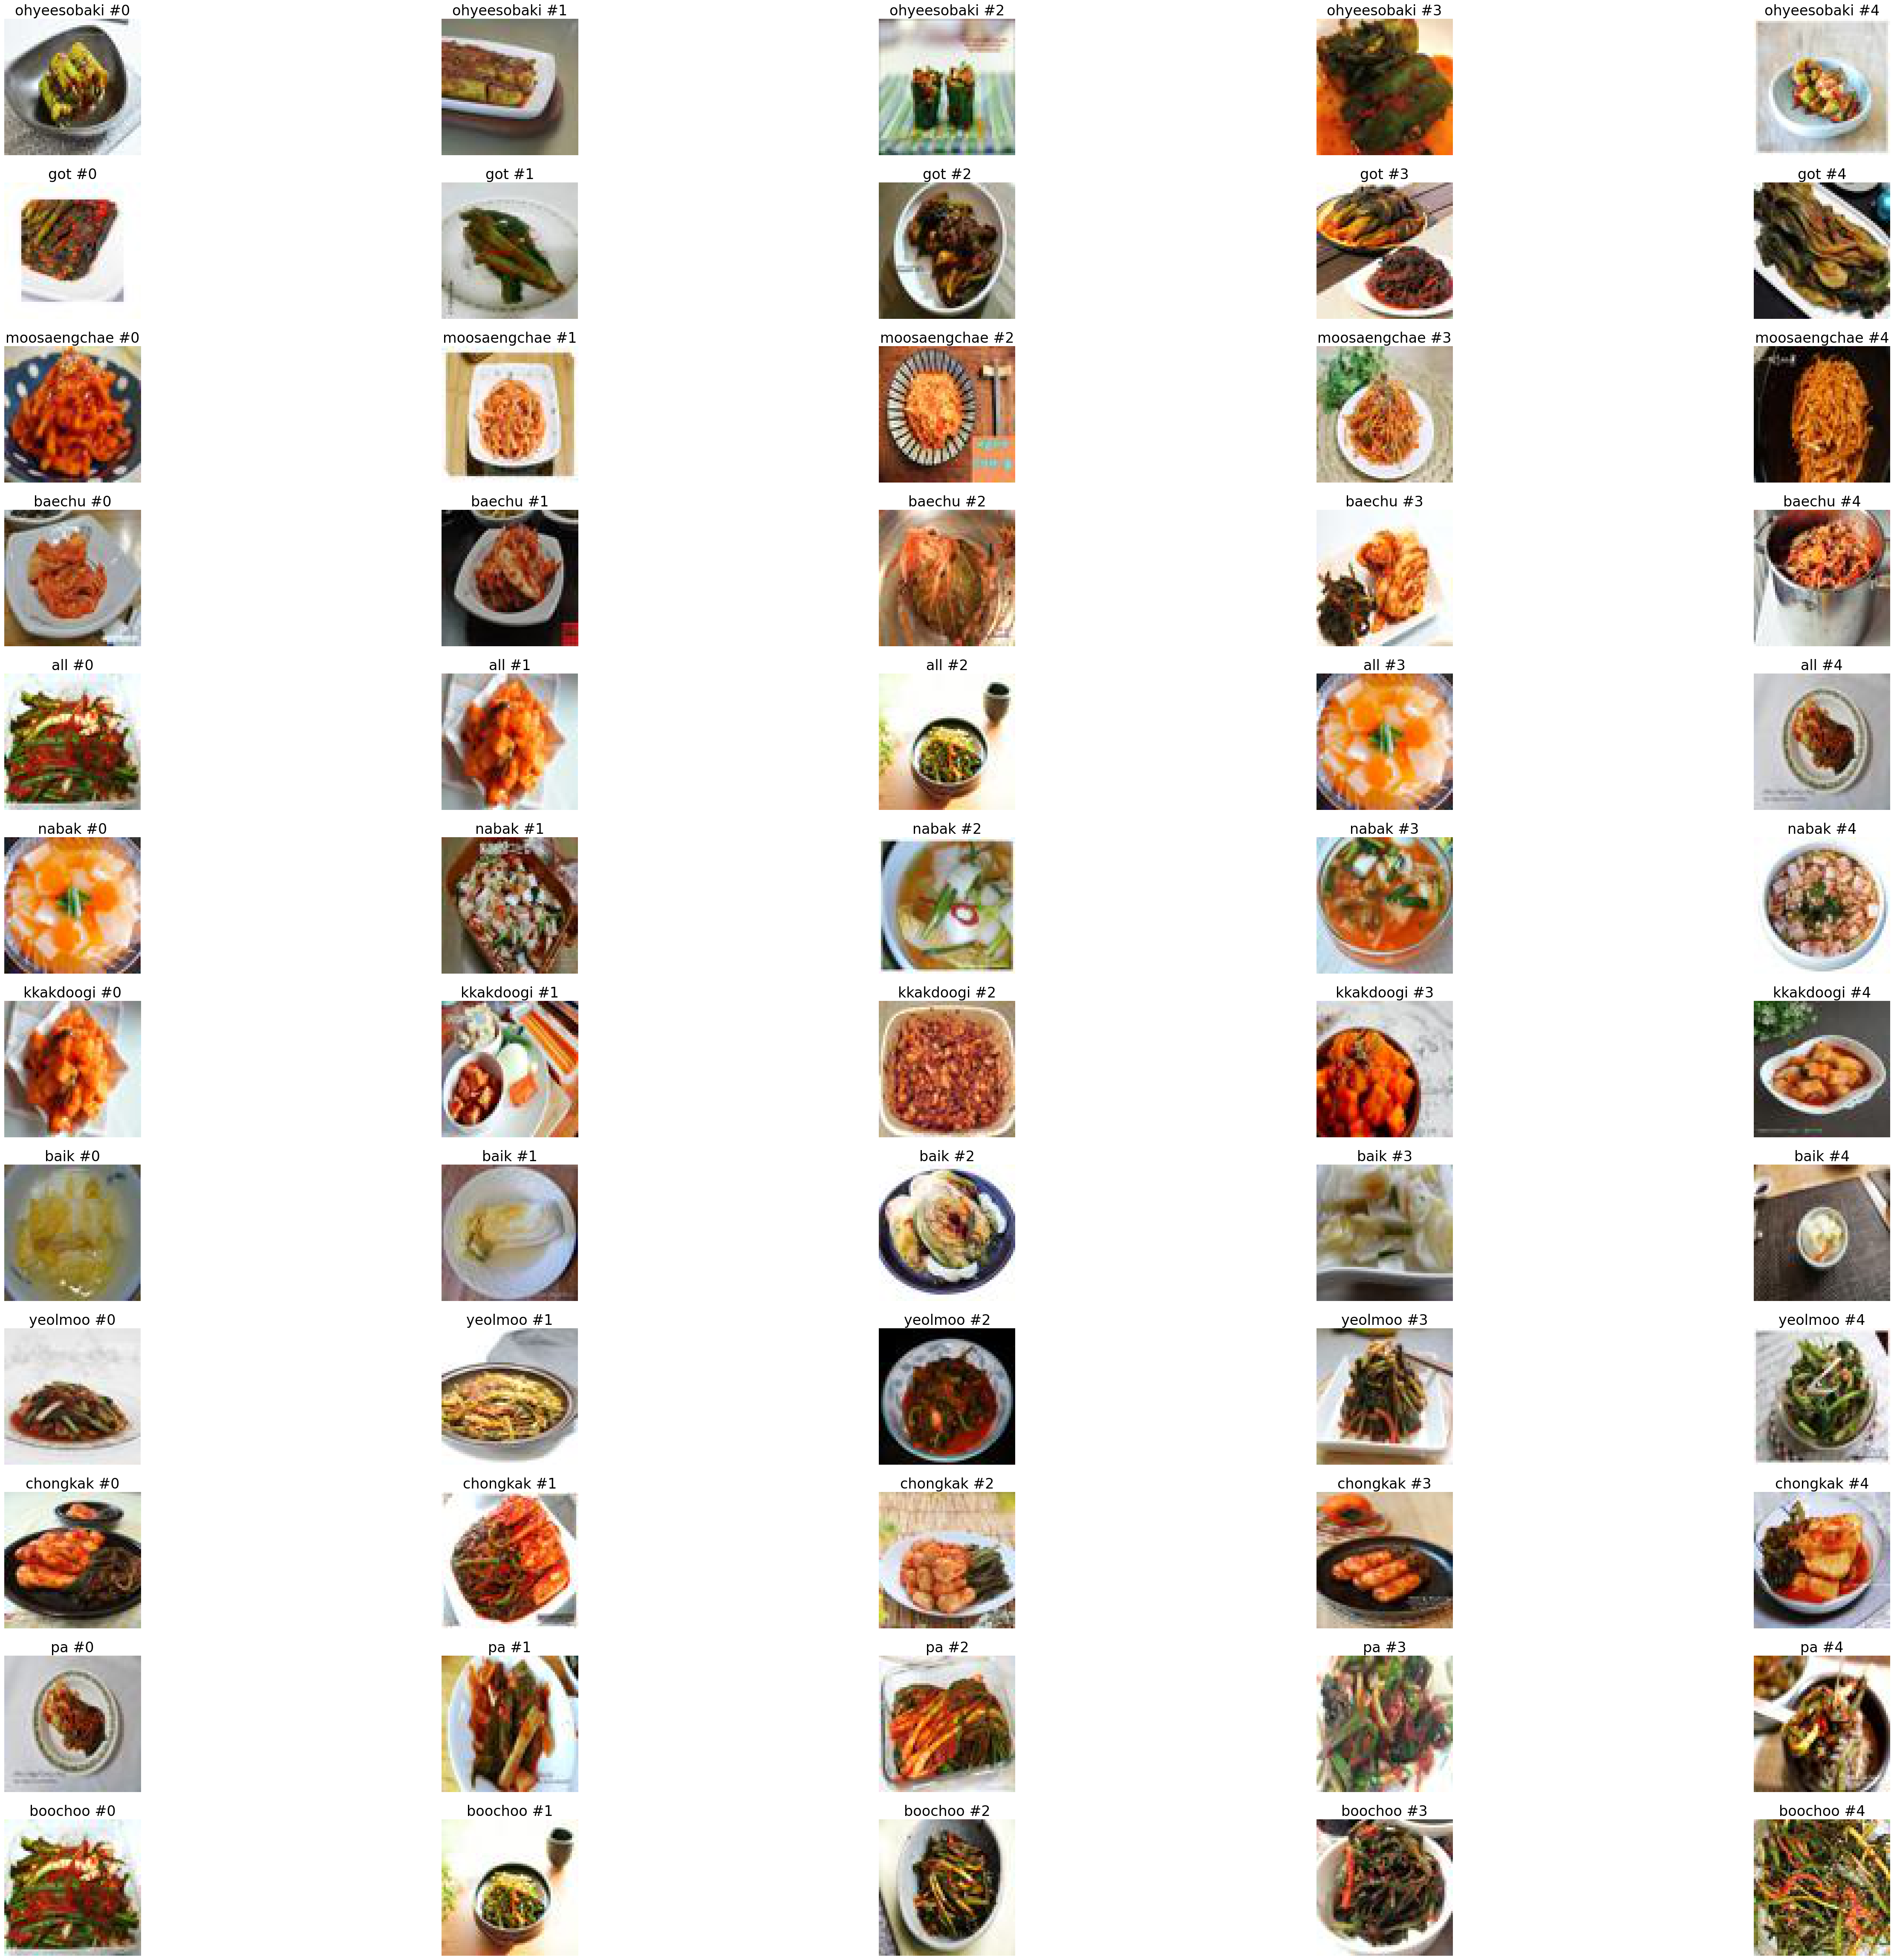

/content/gdrive/MyDrive/dataset_kimchi/dataset


In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
dataset_path = os.path.join(DATASET_ROOT_PATH, 'dataset')
assert DATASET_ROOT_PATH in dataset_path, print(dataset_path)
train_path = os.path.join(dataset_path, 'train')
ks = os.listdir(train_path)
plt.rc('font', size=20)
fig = plt.figure(figsize=(64,64))
fig.tight_layout()
rows = len(ks); cols = 5
idx=1
for r, k in enumerate(ks):
  if k[0]=='.' : continue
  temp_path = os.path.join(train_path, k)
  l=os.listdir(temp_path)[:5]
  for n in range(0, 5):
    ax = fig.add_subplot(rows, cols, idx)
    ax.imshow(Image.open(os.path.join(temp_path, l[n])))
    ax.set_title(f'{ks[r]} #{n}')
    idx+=1
    ax.axis("off")

plt.show()
print(dataset_path)

## DataLoader 구축

### DataSet Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import os
import pickle
class Dataset_kimchi(Dataset):
    '''
    수정금지
    '''
    def __init__(self,
                root_path,
                to_tensor,
                is_train,
                transform=None,) -> None:
        
        self.is_train = is_train # 'train', 'val', 'test'
        
        # label upload #
        self.label_path = os.path.join(root_path, f'{self.is_train}label.pkl')
        with open(self.label_path, 'rb') as f:
            self.labels = pickle.load(f)
            print('trainlabel dictionary loaded successfully from trainlabel.pkl')

        # image upload # 
        self.img_path = os.path.join(root_path, self.is_train, 'all')
        self.images = self.upload_images()
        
        # augmentation #
        self.transform = self.set_augmentation_func(transform)

        # misc #
        self.to_tensor = to_tensor
        
    def __getitem__(self, idx):
        img_name = self.images[idx].split('/')[-1] # Img_033_0000.jpg
        label=self.labels[img_name] # size [12] (one_hot)
        img_raw = read_image(os.path.join(self.images[idx])) # size [c, h, w]
        img_tensor = img_raw.clone().detach()
        img_after_aug = self.transform(img_tensor) if self.transform is not None else img_tensor.clone()
        size = img_after_aug.size()
        
        if self.to_tensor :
            img_after_aug = img_after_aug.clone().detach().type(torch.FloatTensor)
            label = torch.tensor(label).clone().detach().type(torch.FloatTensor)
        return {'img':img_after_aug, 'label':label, 'img_name':img_name, 'size':size}
    
    def __len__(self):
        return len(self.images)
    
    def set_augmentation_func(self, transform):
        '''
        transform = {
            "ColorJitter" : {brightness:(min, max)), contrast:(min, max)), saturation:(min, max)), hue:(min, max))},
            "RandomRotation" : {degrees:(-degrees, +degrees), interpolation:InterpolationMode.NEAREST},
            "RandomCrop" : {size:(sequence or int)},
            "RandomFlip" : {"RandomHorizontalFlip" : 0.5 , "RandomVerticalFlip" : 0.5}
        }
        '''
        aug_ = nn.Sequential()
        print('\nTransform lists')
        print(*transform.items(), sep="\n")
        if transform == None:
            return None
        for aug_name, val in transform.items():
            if val is None :
                continue
            func = getattr(T, aug_name)(**transform[aug_name])
            aug_.append(func)
        return aug_
    
    def upload_images(self):
        print(f'Upload Image from {self.img_path}')
        path_ = self.img_path
        pack=[]
        list_ = os.listdir(path_)
        for t in list_:
            pack.append(os.path.join(path_, t))
        return pack
            
        

### Augmentation

데이터셋의 원본 김치 사진을 Augmentation 합니다.

기존의 Augmentation 값을 바꾸면서 실험해보거나 필요시 참고 자료에서 새로운 Augmentation을 선언하여 사용할 수 있습니다.

참고 자료 : https://pytorch.org/vision/main/transforms.html

In [ ]:
from torchvision.transforms.functional import InterpolationMode

'''
Data Augmentation Parameters 
학습에 민감한 부분이므로 수정하여 성능 변화 관찰
'''
REAL_SIZE=(64, 64) # 실제 이미지 사이즈 (수정금지)
#:::::::::::::::::::::::::::::::::::::::::::::::#
# Color
BRIGHTNESS=(0.5, 1.0) # 밝기 (min, max)
CONTRAST=(.8, 1.5) # 대비 (min, max)
SATURATION=(1.0, 1.9) # 채도 (min, max)
HUE=(-.15, .15) # 색조 (min, max)

# Crop
RANDOMCROP_SIZE=(48,48) # 이미지 랜덤 크롭 사이즈 (h, w)
RANDOMCROP_RATIO=(1.0, 1.0) # 이미지 크롭 랜덤 비율 (min, max)

# Resize
MODEL_INPUT_SIZE = (128, 128) # Model에 적합하도록 이미지를 Resize
PADDING_SIZE=((REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2, (REAL_SIZE[0]-RANDOMCROP_SIZE[0])//2) # 이미지 패딩 사이즈
DEGREES=(-60,60) # 회전 각도 (min, max)
INTERPOLATION=InterpolationMode.BILINEAR # Interpolation 모드 (웬만해서 변경금지)

# Flip
H_FLIP_PROB=0.2 # 이미지 랜덤 세로축 반전 확률 
V_FLIP_PROB=0.2 # 이미지 랜덤 가로축 반전 확률
#:::::::::::::::::::::::::::::::::::::::::::::::#

설정한 Augmentation transform에 적용하기 (Resize는 가장 마지막에 해주세요)

In [ ]:
# (예시)
transform_train = {
#    "ColorJitter" : {'brightness':BRIGHTNESS, 'contrast':CONTRAST, 'saturation':SATURATION, 'hue':HUE},
    "RandomRotation" : {'degrees':DEGREES, 'interpolation': INTERPOLATION},
#   "RandomCrop" : {'size':RANDOMCROP_SIZE},
#    "Pad": {'padding': PADDING_SIZE},
    "RandomResizedCrop" : {'size':REAL_SIZE, 'scale':RANDOMCROP_RATIO},
    "RandomHorizontalFlip" : {'p':H_FLIP_PROB} , 
    "RandomVerticalFlip" : {'p':V_FLIP_PROB},
    "Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION}, # 가장 마지막에 설정
}

transform_test = {"Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION},}


### Dataset, DataLoader 구축 확인

Dataset 선언

In [ ]:
print(dataset_path)
train_dataset = Dataset_kimchi(
                 root_path=dataset_path, 
                 to_tensor=True,
                 is_train="train",
                 transform=transform_train) # init

test_dataset = Dataset_kimchi(
                 root_path=dataset_path, 
                 to_tensor=True,
                 is_train="test",
                 transform=transform_test) # init                 

/content/gdrive/MyDrive/dataset_kimchi/dataset
trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/train/all

Transform lists
('RandomRotation', {'degrees': (-60, 60), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})
('RandomResizedCrop', {'size': (64, 64), 'scale': (1.0, 1.0)})
('RandomHorizontalFlip', {'p': 0.2})
('RandomVerticalFlip', {'p': 0.2})
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})
trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/test/all

Transform lists
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})


배치사이즈 및 DataLoader 선언

In [ ]:
BATCH=64

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Augmentation된 Data 확인

TestSet

torch.Size([3, 128, 128])
boochoo
Augmentation된 이미지


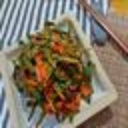


원본이미지


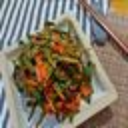

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
idx = 1
EXAMPLE = test_dataset[idx]
REALROOT = test_dataset.images[idx]

img = EXAMPLE['img'] # Tensor형태의 이미지. [C, H, W]
img = img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB 채널
img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
img = cv2.resize(img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경

print(EXAMPLE['img'].shape)
print(kimchi_dict[int(torch.nonzero(EXAMPLE['label'])[0])])
print(f'Augmentation된 이미지')
cv2_imshow(img)
real_img = cv2.imread(REALROOT)
print(f'\n원본이미지')
real_img = cv2.resize(real_img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경
cv2_imshow(real_img)


TrainSet

torch.Size([3, 128, 128])
kkakdoogi
Augmentation된 이미지


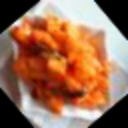


원본이미지


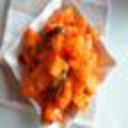

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
idx = 1
EXAMPLE = train_dataset[idx]
REALROOT = train_dataset.images[idx]

img = EXAMPLE['img'] # Tensor형태의 이미지. [C, H, W]
img = img.detach().cpu().numpy() # tensor -> numpy
img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB 채널
img = img.astype(np.uint8).copy() # np.float32 -> np.uint8
img = cv2.resize(img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경

print(EXAMPLE['img'].shape)
print(kimchi_dict[int(torch.nonzero(EXAMPLE['label'])[0])])
print(f'Augmentation된 이미지')
cv2_imshow(img)
real_img = cv2.imread(REALROOT)
print(f'\n원본이미지')
real_img = cv2.resize(real_img, dsize=MODEL_INPUT_SIZE) # visualization을 위한 사이즈 변경
cv2_imshow(real_img)

## 학습 준비를 위한 모델, Optimizer 초기화

### 모델 선언

### Model Parameters를 수정해서 자신만의 ViT를 만들어보고 성능을 향상시켜보세요

  아래부분만 바꾸시면 되겠습니다!

  Cifar 10에서 학습한 모델을 참고 하셔도 좋습니다.

In [ ]:
NUM_CLASSES = 11
#################### MODEL PARAMETERS (수정가능)
PATCH_SIZE = (16,16)
DIM = 128
DEPTH = 6
NUM_HEADS = 16
MLP_DIM = 128
DROPOUT = 0.3
EMB_DROPOUT = 0.3
####################

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

model = ViT(
    image_size = MODEL_INPUT_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = NUM_CLASSES,
    dim = DIM,
    depth = DEPTH,
    heads = NUM_HEADS,
    mlp_dim = MLP_DIM,
    dropout = DROPOUT,
    emb_dropout = EMB_DROPOUT
)

model = model.to(device)
print(next(model.parameters()).device)
print(model)

cuda
cuda:0
ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=128, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=128, bias=True)
              (1): Dropout(p=0.3, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): GELU(

### Optimizer

In [ ]:
LR = 2e-4
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# 그 밖의 Optimizer 설정 가능 (예시)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.RAdam(model.parameters(), lr=LR)

에폭 설정

In [ ]:
EPOCHS = 50

## 학습 코드

In [ ]:
import warnings

warnings.filterwarnings("ignore") 

EXPERIMENT_NAME : 실험 이름을 설정해서 실험을 체계적으로 관리하세요

In [ ]:
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
import torch.nn as nn

# 실험이름 설정
EXPERIMENT_NAME="train1"
os.makedirs(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',exist_ok=True)

DATASET_SIZE = len(train_dataloader.dataset)
ITER_PER_EPOCH = DATASET_SIZE // BATCH
TOTAL_ITER = ITER_PER_EPOCH * EPOCHS

print(f"""
::::::::::::::::::::::
DATASET_SIZE : {DATASET_SIZE}
BATCH_SIZE : {BATCH}
INIT_LR : {LR}
TOTAL_EPOCHS : {EPOCHS}
ITER_PER_EPOCH : {ITER_PER_EPOCH}
TOTAL_ITER : {TOTAL_ITER}
OPT : {optimizer.__class__}
MODEL_INPUT_SIZE : {MODEL_INPUT_SIZE}
PATCH_SIZE : {PATCH_SIZE}
NUM_CLASSES : {NUM_CLASSES}
PATCH_DIM : {DIM}
MLP_DIM : {MLP_DIM}
DEPTH : {DEPTH}
NUM_HEADS : {NUM_HEADS}
::::::::::::::::::::::
""") 

# Model Output 정규화 함수

best_acc = -1
best_acc_test = -1
for epoch in range(1,EPOCHS+1):
    model.train()
    total_loss = 0
    correct_prediction = 0
    acc_list = []
    print(f"Training {epoch}/{EPOCHS} Epoch")
    for idx, pack in enumerate(tqdm(train_dataloader)):
        X = pack['img'].to(device)
        Y = pack['label'].to(device)
        outputs, attn = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss / BATCH

        # Train Acc Check
        outputs_ = torch.argmax(outputs, 1)
        outputs_ = outputs_.clone().detach().cpu().numpy()

        Y = torch.nonzero(Y, as_tuple=True)[1]
        Y_ = Y.clone().detach().cpu().numpy()

        # correct_prediction += (torch.argmax(outputs, 1) == Y).sum()
        acc = accuracy_score(Y_, outputs_)
        acc_list.append(acc)
    acc = np.mean(acc_list)
    
    correct_prediction = correct_prediction/DATASET_SIZE
    print(f'[Epoch: {epoch}] training loss = {total_loss:.3}, training accuracy: {acc*100:.3}%')
    
    # Model Evaluation
    
    model.eval()
    with torch.no_grad():
      acc_list_test = []
      for idx, pack in enumerate(test_dataloader):
          X = pack['img'].to(device)
          Y = pack['label'].to(device)
          outputs, attn = model(X)
          outputs_ = torch.argmax(outputs, 1)
          outputs_ = outputs_.clone().detach().cpu().numpy()
          labels = Y
          
          Y = torch.nonzero(Y, as_tuple=True)[1]
          Y_ = Y.clone().detach().cpu().numpy()
          acc_test = accuracy_score(Y_, outputs_)
          acc_list_test.append(acc_test)
      
      acc_test = np.mean(acc_list_test)

      # Best TestSet Accuracy 일 때 체크포인트를 저장합니다.
      if best_acc_test < acc_test*100:
          best_acc_test = acc_test*100
          torch.save(model.state_dict(), 
                      os.path.join(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',
                                  'model_best.pt'))
          print("best model saved")
      print(f'test set accuracy: {acc_test*100:.3}%\n')
print('Train Finished')


::::::::::::::::::::::
DATASET_SIZE : 8800
BATCH_SIZE : 64
INIT_LR : 0.0002
TOTAL_EPOCHS : 50
ITER_PER_EPOCH : 137
TOTAL_ITER : 6850
OPT : <class 'torch.optim.adamw.AdamW'>
MODEL_INPUT_SIZE : (128, 128)
PATCH_SIZE : (16, 16)
NUM_CLASSES : 11
PATCH_DIM : 128
MLP_DIM : 128
DEPTH : 6
NUM_HEADS : 16
::::::::::::::::::::::

Training 1/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.91it/s]


[Epoch: 1] training loss = 4.79, training accuracy: 17.1%
best model saved
test set accuracy: 24.6%

Training 2/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.95it/s]


[Epoch: 2] training loss = 4.25, training accuracy: 26.5%
best model saved
test set accuracy: 29.3%

Training 3/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


[Epoch: 3] training loss = 4.05, training accuracy: 30.3%
best model saved
test set accuracy: 31.5%

Training 4/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.76it/s]


[Epoch: 4] training loss = 3.82, training accuracy: 34.0%
best model saved
test set accuracy: 36.0%

Training 5/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 5] training loss = 3.66, training accuracy: 37.1%
best model saved
test set accuracy: 39.2%

Training 6/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.81it/s]


[Epoch: 6] training loss = 3.54, training accuracy: 39.3%
test set accuracy: 37.2%

Training 7/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.74it/s]


[Epoch: 7] training loss = 3.45, training accuracy: 40.9%
best model saved
test set accuracy: 43.9%

Training 8/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.84it/s]


[Epoch: 8] training loss = 3.36, training accuracy: 43.2%
best model saved
test set accuracy: 44.0%

Training 9/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.95it/s]


[Epoch: 9] training loss = 3.29, training accuracy: 43.5%
best model saved
test set accuracy: 46.5%

Training 10/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.84it/s]


[Epoch: 10] training loss = 3.25, training accuracy: 44.7%
best model saved
test set accuracy: 47.9%

Training 11/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


[Epoch: 11] training loss = 3.16, training accuracy: 46.6%
best model saved
test set accuracy: 48.6%

Training 12/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.78it/s]


[Epoch: 12] training loss = 3.11, training accuracy: 47.0%
test set accuracy: 47.5%

Training 13/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.86it/s]


[Epoch: 13] training loss = 3.07, training accuracy: 47.6%
test set accuracy: 48.6%

Training 14/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


[Epoch: 14] training loss = 3.04, training accuracy: 48.6%
best model saved
test set accuracy: 50.5%

Training 15/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.85it/s]


[Epoch: 15] training loss = 2.98, training accuracy: 49.2%
test set accuracy: 49.1%

Training 16/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.75it/s]


[Epoch: 16] training loss = 2.94, training accuracy: 50.4%
best model saved
test set accuracy: 51.9%

Training 17/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 17] training loss = 2.93, training accuracy: 50.8%
best model saved
test set accuracy: 52.2%

Training 18/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.85it/s]


[Epoch: 18] training loss = 2.87, training accuracy: 51.2%
best model saved
test set accuracy: 53.0%

Training 19/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 19] training loss = 2.86, training accuracy: 52.0%
best model saved
test set accuracy: 53.0%

Training 20/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


[Epoch: 20] training loss = 2.83, training accuracy: 52.1%
best model saved
test set accuracy: 53.7%

Training 21/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


[Epoch: 21] training loss = 2.82, training accuracy: 52.2%
best model saved
test set accuracy: 55.1%

Training 22/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 22] training loss = 2.79, training accuracy: 52.9%
test set accuracy: 55.0%

Training 23/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.81it/s]


[Epoch: 23] training loss = 2.79, training accuracy: 52.9%
best model saved
test set accuracy: 56.5%

Training 24/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.97it/s]


[Epoch: 24] training loss = 2.76, training accuracy: 53.6%
test set accuracy: 54.5%

Training 25/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.96it/s]


[Epoch: 25] training loss = 2.73, training accuracy: 53.4%
test set accuracy: 54.8%

Training 26/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.85it/s]


[Epoch: 26] training loss = 2.72, training accuracy: 54.2%
best model saved
test set accuracy: 56.9%

Training 27/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


[Epoch: 27] training loss = 2.68, training accuracy: 55.2%
test set accuracy: 56.0%

Training 28/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.90it/s]


[Epoch: 28] training loss = 2.65, training accuracy: 55.2%
test set accuracy: 56.2%

Training 29/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.67it/s]


[Epoch: 29] training loss = 2.66, training accuracy: 55.8%
best model saved
test set accuracy: 57.2%

Training 30/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.88it/s]


[Epoch: 30] training loss = 2.64, training accuracy: 56.2%
best model saved
test set accuracy: 58.0%

Training 31/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.88it/s]


[Epoch: 31] training loss = 2.61, training accuracy: 56.4%
test set accuracy: 56.8%

Training 32/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


[Epoch: 32] training loss = 2.64, training accuracy: 54.6%
test set accuracy: 57.2%

Training 33/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.79it/s]


[Epoch: 33] training loss = 2.58, training accuracy: 56.7%
test set accuracy: 57.3%

Training 34/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


[Epoch: 34] training loss = 2.59, training accuracy: 56.2%
best model saved
test set accuracy: 58.2%

Training 35/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


[Epoch: 35] training loss = 2.58, training accuracy: 57.0%
test set accuracy: 57.8%

Training 36/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.86it/s]


[Epoch: 36] training loss = 2.55, training accuracy: 57.3%
best model saved
test set accuracy: 58.8%

Training 37/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


[Epoch: 37] training loss = 2.53, training accuracy: 57.5%
test set accuracy: 58.4%

Training 38/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.91it/s]


[Epoch: 38] training loss = 2.52, training accuracy: 57.8%
test set accuracy: 55.7%

Training 39/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


[Epoch: 39] training loss = 2.5, training accuracy: 58.0%
best model saved
test set accuracy: 59.0%

Training 40/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.82it/s]


[Epoch: 40] training loss = 2.52, training accuracy: 58.1%
test set accuracy: 59.0%

Training 41/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 41] training loss = 2.5, training accuracy: 58.6%
test set accuracy: 58.1%

Training 42/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.74it/s]


[Epoch: 42] training loss = 2.49, training accuracy: 57.8%
test set accuracy: 57.8%

Training 43/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.98it/s]


[Epoch: 43] training loss = 2.48, training accuracy: 59.2%
test set accuracy: 57.3%

Training 44/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.81it/s]


[Epoch: 44] training loss = 2.47, training accuracy: 58.7%
test set accuracy: 58.2%

Training 45/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


[Epoch: 45] training loss = 2.47, training accuracy: 58.7%
test set accuracy: 57.2%

Training 46/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.81it/s]


[Epoch: 46] training loss = 2.43, training accuracy: 59.6%
best model saved
test set accuracy: 61.0%

Training 47/50 Epoch


100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


[Epoch: 47] training loss = 2.42, training accuracy: 59.5%
test set accuracy: 58.4%

Training 48/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


[Epoch: 48] training loss = 2.44, training accuracy: 58.8%
test set accuracy: 59.9%

Training 49/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.79it/s]


[Epoch: 49] training loss = 2.38, training accuracy: 61.1%
test set accuracy: 60.2%

Training 50/50 Epoch


100%|██████████| 138/138 [00:20<00:00,  6.88it/s]


[Epoch: 50] training loss = 2.41, training accuracy: 59.7%
test set accuracy: 59.5%

Train Finished


## 학습된 모델 성능 평가 (Test Dataset)

### 테스트 DataSet 구축



In [ ]:
transform_test = {"Resize": {'size':MODEL_INPUT_SIZE, 'interpolation':INTERPOLATION},}

test_dataset = Dataset_kimchi(
                 root_path=dataset_path, 
                 to_tensor=True,
                 is_train="test",
                 transform=transform_test) # init

trainlabel dictionary loaded successfully from trainlabel.pkl
Upload Image from /content/gdrive/MyDrive/dataset_kimchi/dataset/test/all

Transform lists
('Resize', {'size': (128, 128), 'interpolation': <InterpolationMode.BILINEAR: 'bilinear'>})


Test시에는 Batch Size를 1로 설정합니다.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

모델 체크포인트 불러오기 (Best Model)

In [ ]:
CHECKPOINT_PATH = os.path.join(f'{dataset_path}/checkpoint_kimchi/{EXPERIMENT_NAME}',
                                    'model_best.pt')
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model = model.to(device)

### 성능 평가

성능 평가를 위한 코드

100%|██████████| 2200/2200 [00:14<00:00, 152.12it/s]


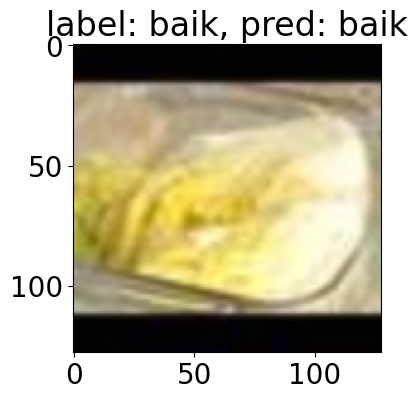

Accuracy of the network on the test images: 61.0 %


In [ ]:
img_num = 10

model.eval()
fig = plt.figure(figsize=(30,4))

kimchi_list = ['baechu', 'baik', 'boochoo', 'chongkak', 'got', 'kkakdoogi', 'moosaengchae', 'nabak', 'ohyeesobaki', 'pa', 'yeolmoo']
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다

with torch.no_grad():
    acc_list = []
    for idx, pack in enumerate(tqdm(test_dataloader)):
        X = pack['img'].to(device)
        Y = pack['label'].to(device)
        labels = Y
        img = X.cpu().detach()
        img = img.permute(0,2,3,1).numpy().astype(np.int64)
        
        outputs, attn = model(X)
        outputs_ = torch.argmax(outputs, 1)
        outputs_ = outputs_.clone().detach().cpu().numpy()
        Y = torch.nonzero(Y, as_tuple=True)[1]
        Y_ = Y.clone().detach().cpu().numpy()

        acc = accuracy_score(Y_, outputs_)
        acc_list.append(acc)

    plt.imshow(img[0])
    plt.title('label: '+kimchi_list[torch.argmax(labels[0])] + f', pred: {kimchi_list[outputs_[0]]}')
    plt.show()

    acc = np.mean(acc_list)
    print(f'Accuracy of the network on the test images: {acc*100:.3} %')

## [Bonus] 실제 사진으로 성능 평가


실제 김치 사진을 촬영해서 Colab 환경에 업로드 해보세요 (휴대폰으로 촬영 한 다음 개인 컴퓨터에 업로드 되어 있어야 합니다.)

In [ ]:
from google.colab import files
uploaded = files.upload()

img_name = list(uploaded.keys())[0]

Saving images.jpg to images (1).jpg


In [ ]:
from PIL import Image
  
image = Image.open(f'{img_name}').convert("RGB") 
  
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize(size=MODEL_INPUT_SIZE, interpolation=InterpolationMode.BILINEAR)
])
img_tensor = transform(image)
img_tensor = img_tensor.unsqueeze(0).to(device)
img_tensor = img_tensor.type(torch.float32)

In [ ]:
softmax = nn.Softmax()
probabilities, attn = model(img_tensor)
probabilities = softmax(probabilities)
probabilities = torch.squeeze(probabilities)
kimchi_list = ['baechu', 'baik', 'boochoo', 'chongkak', 'got', 'kkakdoogi', 'moosaengchae', 'nabak', 'ohyeesobaki', 'pa', 'yeolmoo']
output_data = dict()
for i in range(0, 11):
  score = round(probabilities[i].item(),3) * 100
  print(kimchi_list[i] + " : " + f'{score:.2f}%')
  output_data[kimchi_list[i]] = round(probabilities[i].item(),3) * 100

baechu : 12.90%
baik : 0.70%
boochoo : 0.00%
chongkak : 1.90%
got : 0.00%
kkakdoogi : 17.20%
moosaengchae : 59.80%
nabak : 5.20%
ohyeesobaki : 2.20%
pa : 0.10%
yeolmoo : 0.00%


### Output Visualization

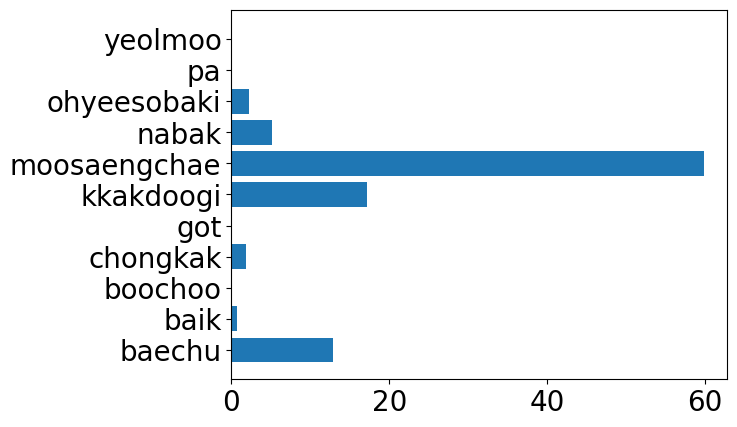

In [ ]:
import matplotlib.pyplot as plt
x = list(output_data.keys())
y = list(output_data.values())

plt.barh(range(len(output_data)), y, tick_label = x)
plt.show()

torch.Size([3, 130, 130])
torch.Size([130, 130, 3])


Text(0.5, 1.0, 'pred: moosaengchae , prob: 59.80')

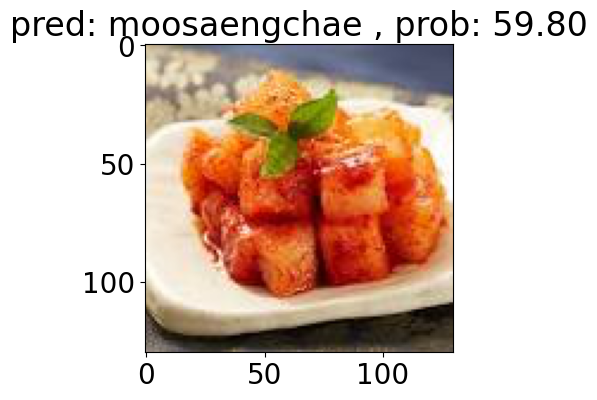

In [ ]:
fig = plt.figure(figsize=(30,4))

y = np.array(y)
max_idx = np.argmax(y)
label = kimchi_list[max_idx]
pred = y[max_idx]


tf = transforms.ToTensor()
image_t = tf(image)
print(image_t.size())

image_t = image_t.permute(1, 2, 0)
print(image_t.size())


plt.imshow(image_t)
plt.title('pred: ' + str(label) + ' , prob: ' + f'{pred:.2f}')